In [15]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [16]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [78]:
file = tf.keras.utils
df1 = pd.read_csv('../data/2020/20_agg_data.csv')
df2 = pd.read_csv('../data/2019/19_agg_data.csv')
df3 = pd.read_csv('../data/2018/18_agg_data.csv')
df_dict = {
    'df1': df1,
    'df2': df2,
    'df3': df3
}
df_list = [df1, df2, df3]

In [24]:
comb_df = pd.concat([df1, df2])
comb_df.describe()

,Time,Max Concentration,Last Pit,Air Temp,Track Temp,Humidity,Pressure,Wind Speed,Yellow
count,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000
mean,39110.017331,6.534720,50.757217,56.331250,58.295031,62.076923,30.095822,2.331382,0.010132
std,23558.265622,3.376185,18.238347,5.774178,9.953347,13.746285,0.047763,2.221781,0.100153
min,20.000000,1.400560,0.333333,46.400000,32.000000,34.000000,29.976005,0.000000,0.000000
25%,18780.000000,4.118051,40.752017,52.700000,53.999960,55.000000,30.057212,0.600000,0.000000
50%,38520.000000,5.376344,49.508350,55.999940,57.000020,60.000000,30.098259,1.900000,0.000000
75%,57300.000000,8.333333,55.131033,60.099980,60.999980,76.000000,30.125132,3.900000,0.000000
max,86380.000000,33.333333,129.998767,68.599940,98.000060,92.000000,30.182125,15.100000,1.000000


In [25]:
neg, pos = np.bincount(comb_df['Yellow'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 7501
    Positive: 76 (1.01% of total)



In [26]:
cleaned_df = comb_df.copy()
cleaned_df.pop('Time')

eps = 0.001 
cleaned_df['Last Pit'] = np.log(cleaned_df['Last Pit']+eps)

In [27]:
cleaned_df.describe()

,Max Concentration,Last Pit,Air Temp,Track Temp,Humidity,Pressure,Wind Speed,Yellow
count,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000
mean,6.534720,3.859298,56.331250,58.295031,62.076923,30.095822,2.331382,0.010132
std,3.376185,0.408168,5.774178,9.953347,13.746285,0.047763,2.221781,0.100153
min,1.400560,-1.095617,46.400000,32.000000,34.000000,29.976005,0.000000,0.000000
25%,4.118051,3.707530,52.700000,53.999960,55.000000,30.057212,0.600000,0.000000
50%,5.376344,3.902162,55.999940,57.000020,60.000000,30.098259,1.900000,0.000000
75%,8.333333,4.009731,60.099980,60.999980,76.000000,30.125132,3.900000,0.000000
max,33.333333,4.867533,68.599940,98.000060,92.000000,30.182125,15.100000,1.000000


In [28]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, val_df = train_test_split(cleaned_df, test_size=0.2)
test_df = df3
test_df.pop('Time')

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Yellow'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Yellow'))
test_labels = np.array(test_df.pop('Yellow'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [29]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (6000,)
Validation labels shape: (1501,)
Test labels shape: (4312,)
Training features shape: (6000, 7)
Validation features shape: (1501, 7)
Test features shape: (4312, 7)


C:\Users\dithu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\dithu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


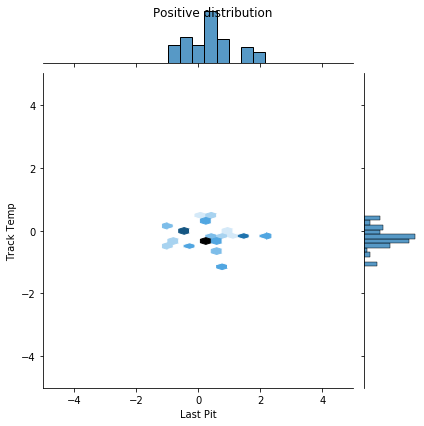

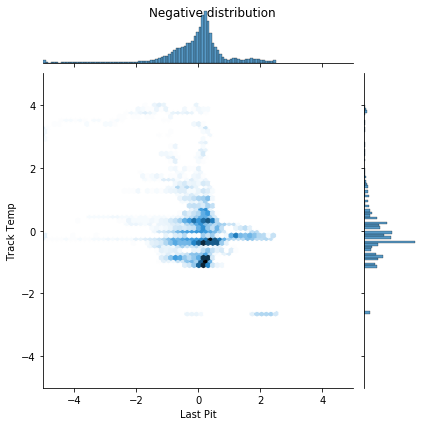

In [30]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['Last Pit'], pos_df['Track Temp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['Last Pit'], neg_df['Track Temp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [39]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None, dropout=0.5):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(dropout),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [40]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [41]:
model = make_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.predict(train_features[:10])

array([[0.2291134 ],
       [0.35613722],
       [0.18573648],
       [0.32598665],
       [0.38863194],
       [0.37885576],
       [0.32074955],
       [0.24920362],
       [0.3329996 ],
       [0.26103765]], dtype=float32)

In [43]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3256


In [44]:
initial_bias = np.log([pos/neg])
initial_bias

array([-4.58187462])

In [45]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00368345],
       [0.01082009],
       [0.00554037],
       [0.00888419],
       [0.00837153],
       [0.02076483],
       [0.00719318],
       [0.01000682],
       [0.00948137],
       [0.00935367]], dtype=float32)

In [46]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0595


In [47]:
initial_weights = '../data/inital_weights'
model.save_weights(initial_weights)

In [48]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [49]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [50]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

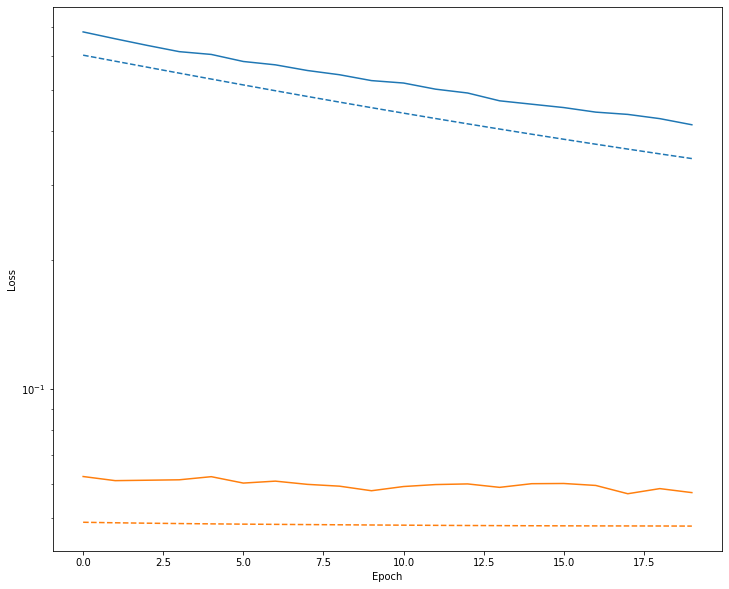

In [51]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

BASELINE

In [52]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    verbose=0
)

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping


In [53]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.4,.8])
        else:
            plt.ylim([-0.1,1])

        plt.legend()

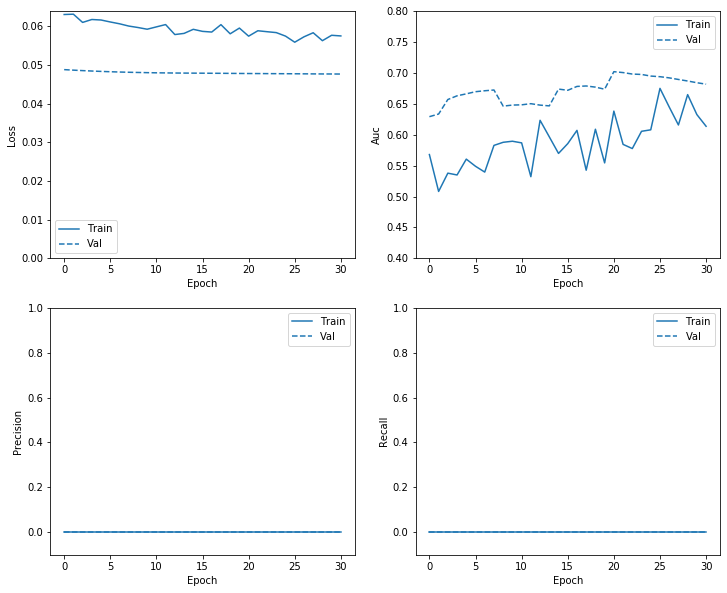

In [54]:
plot_metrics(baseline_history)

In [55]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [56]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Green Flags Predicted (True Negatives): ', cm[0][0])
    print('Yellow Flags Incorrectly Predicted (False Positives): ', cm[0][1])
    print('Yellow Flags Missed (False Negatives): ', cm[1][0])
    print('Yellow Flags Correctly Predicted (True Positives): ', cm[1][1])
    print('Total Yellow Flags: ', np.sum(cm[1]))

loss :  0.027320219203829765
tp :  0.0
fp :  0.0
tn :  4296.0
fn :  16.0
accuracy :  0.9962894320487976
precision :  0.0
recall :  0.0
auc :  0.4902161955833435

Green Flags Predicted (True Negatives):  4296
Yellow Flags Incorrectly Predicted (False Positives):  0
Yellow Flags Missed (False Negatives):  16
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  16


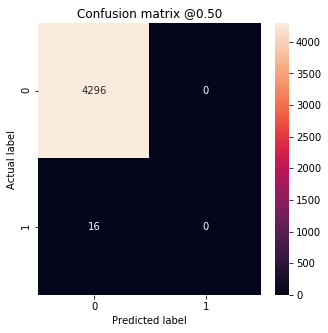

In [57]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [58]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

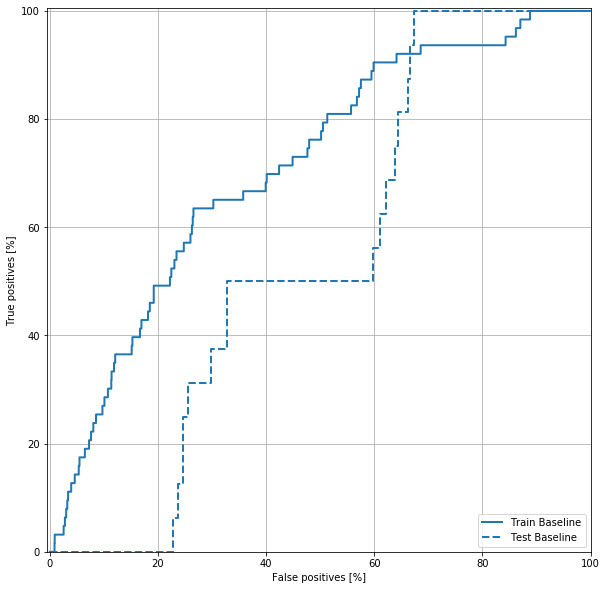

In [59]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

WEIGHTED

In [60]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 98.70


In [61]:
weighted_model = make_model(dropout=.5)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight,
    verbose=0
)

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


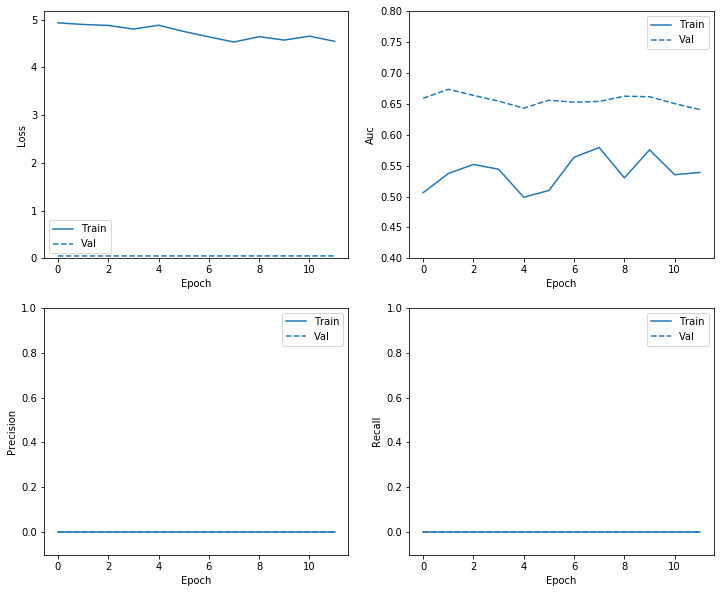

In [62]:
plot_metrics(weighted_history)

In [63]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.02773812972009182
tp :  0.0
fp :  0.0
tn :  4296.0
fn :  16.0
accuracy :  0.9962894320487976
precision :  0.0
recall :  0.0
auc :  0.4854006767272949

Green Flags Predicted (True Negatives):  4296
Yellow Flags Incorrectly Predicted (False Positives):  0
Yellow Flags Missed (False Negatives):  16
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  16


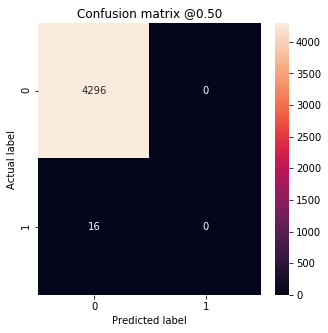

In [64]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

RESAMPLED

In [65]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [66]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [67]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-0.58273727 -0.32009765  0.07768431 -0.02985873 -0.72719431  1.14587842
  1.60973203]

Label:  1


In [68]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.37, 0.63])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [69]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.3681640625


In [70]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

8.0

In [71]:
resampled_model = make_model(dropout=0.2)
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds,
    verbose=0
)

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping


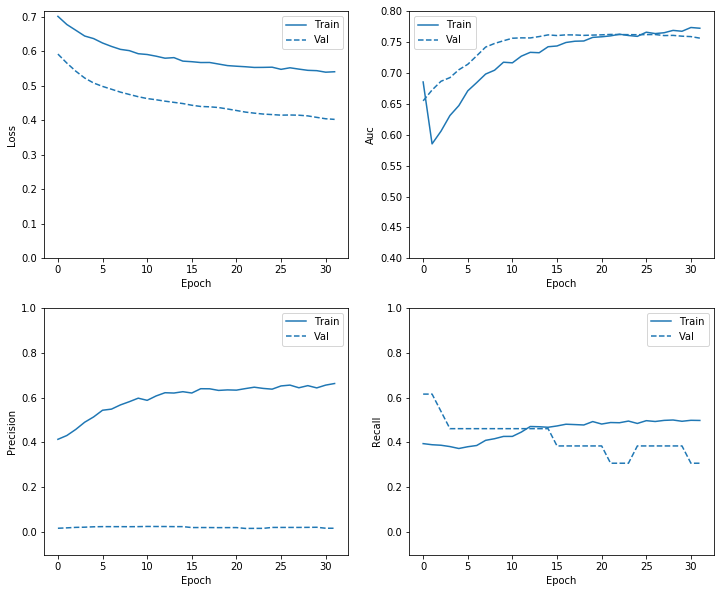

In [72]:
plot_metrics(resampled_history)

In [73]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.46483561396598816
tp :  0.0
fp :  119.0
tn :  4177.0
fn :  16.0
accuracy :  0.9686920046806335
precision :  0.0
recall :  0.0
auc :  0.5474932789802551

Green Flags Predicted (True Negatives):  4177
Yellow Flags Incorrectly Predicted (False Positives):  119
Yellow Flags Missed (False Negatives):  16
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  16


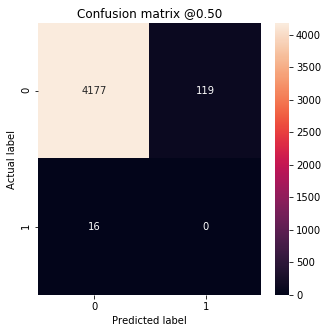

In [74]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

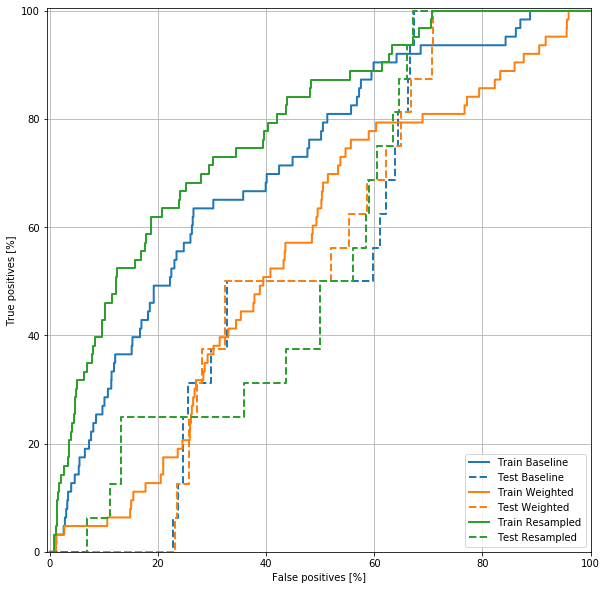

In [75]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

Testing on df 1
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
loss :  0.6578763127326965
tp :  11.0
fp :  1542.0
tn :  2747.0
fn :  13.0
accuracy :  0.6394621133804321
precision :  0.007083064876496792
recall :  0.4583333432674408
auc :  0.5455671548843384



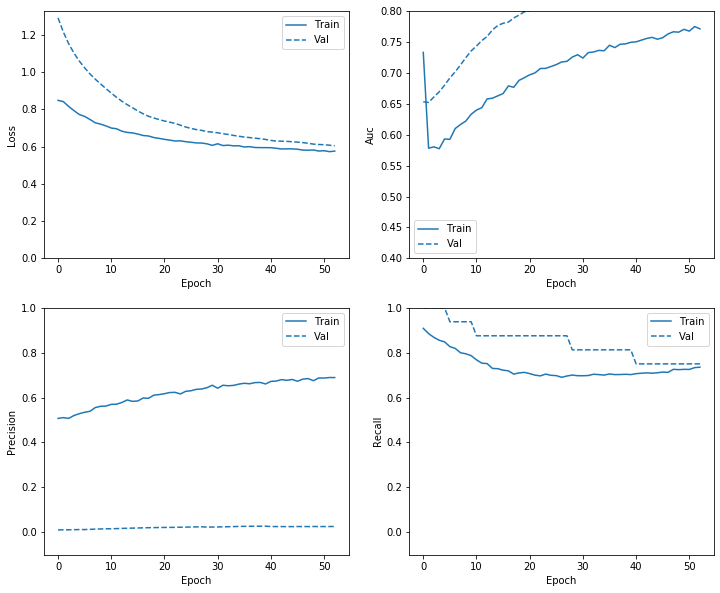

Green Flags Predicted (True Negatives):  2747
Yellow Flags Incorrectly Predicted (False Positives):  1542
Yellow Flags Missed (False Negatives):  13
Yellow Flags Correctly Predicted (True Positives):  11
Total Yellow Flags:  24


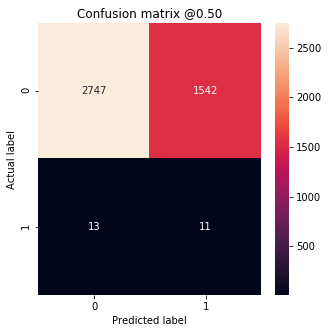

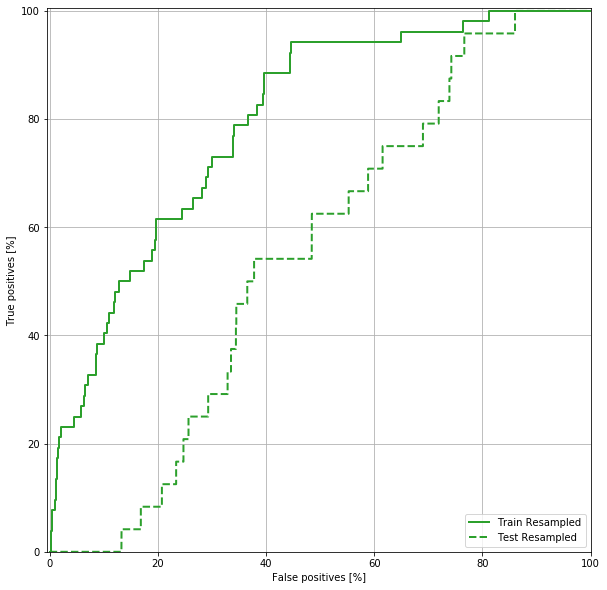

Testing on df 2
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
loss :  0.4951149523258209
tp :  0.0
fp :  464.0
tn :  2672.0
fn :  52.0
accuracy :  0.8381430506706238
precision :  0.0
recall :  0.0
auc :  0.3371148705482483



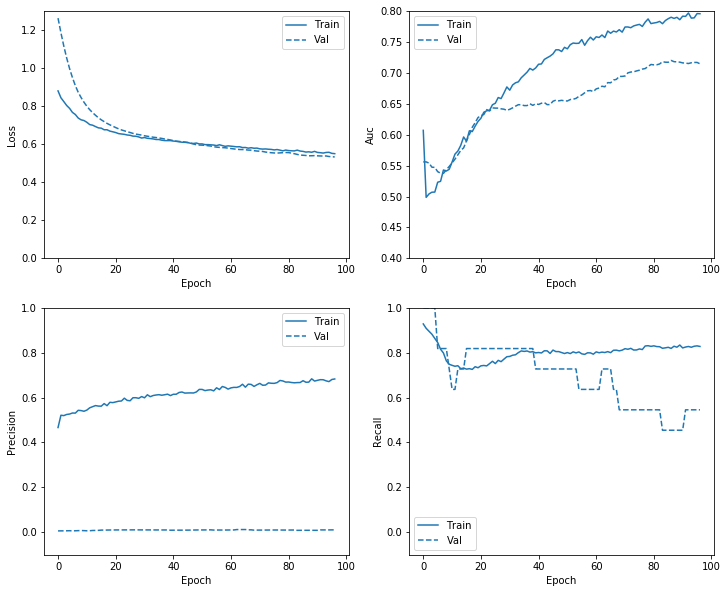

Green Flags Predicted (True Negatives):  2672
Yellow Flags Incorrectly Predicted (False Positives):  464
Yellow Flags Missed (False Negatives):  52
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  52


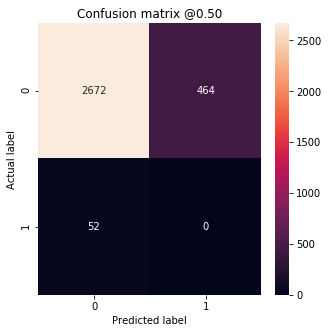

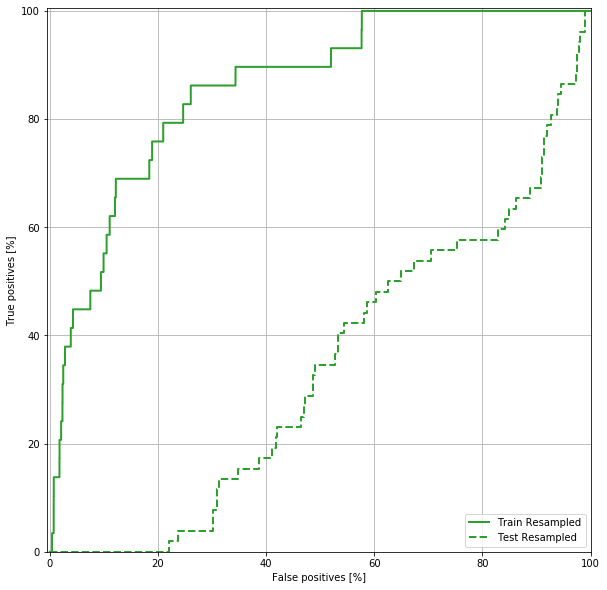

Testing on df 3
loss :  0.22900572419166565
tp :  0.0
fp :  0.0
tn :  4296.0
fn :  16.0
accuracy :  0.9962894320487976
precision :  0.0
recall :  0.0
auc :  0.6104443073272705



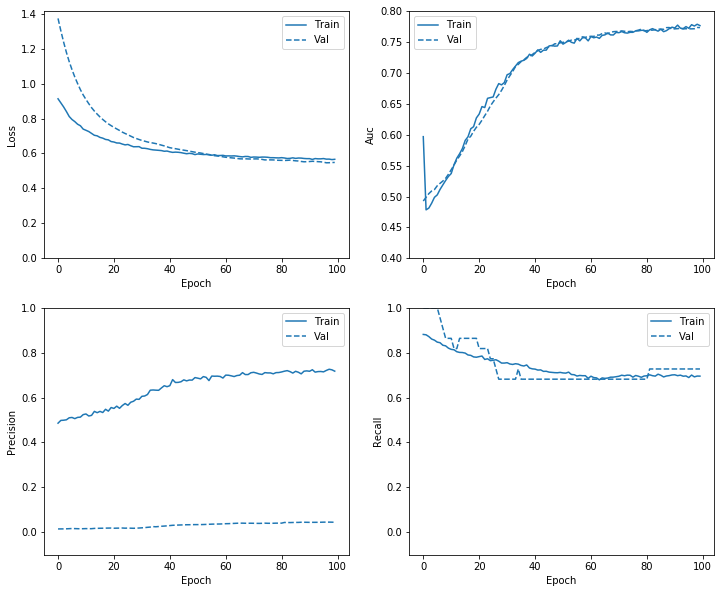

Green Flags Predicted (True Negatives):  4296
Yellow Flags Incorrectly Predicted (False Positives):  0
Yellow Flags Missed (False Negatives):  16
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  16


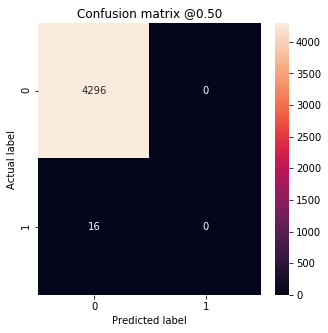

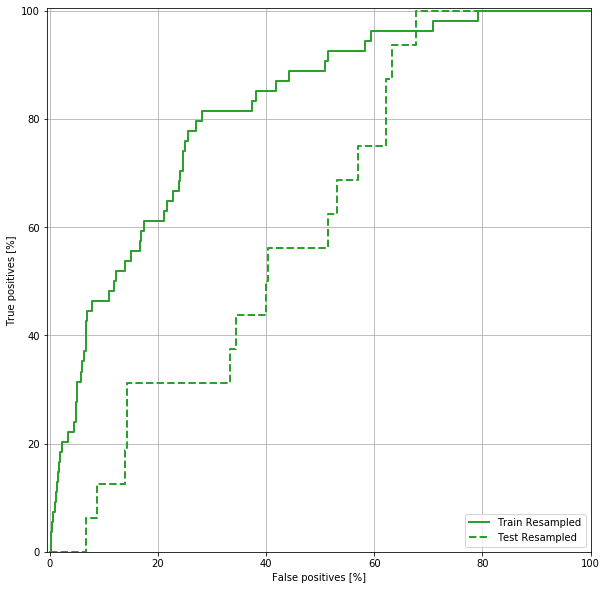

In [92]:
for i in range(0, 3):
    df1 = pd.read_csv('../data/2020/20_agg_data.csv')
    df2 = pd.read_csv('../data/2019/19_agg_data.csv')
    df3 = pd.read_csv('../data/2018/18_agg_data.csv')
    df_list = [df1, df2, df3]
    
    print('Testing on df', str(i+1))
    test_df = df_list[i]
    test_df.pop('Time')
#     print(test_df.head)
    
    train_list = df_list[:i] + df_list[i+1:]
    train_df = pd.concat(train_list) 
    train_df.pop('Time')
#     print(train_df.head)

    eps = 0.001 
    train_df['Last Pit'] = np.log(train_df['Last Pit']+eps)
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    # Form np arrays of labels and features.
    train_labels = np.array(train_df.pop('Yellow'))
    bool_train_labels = train_labels != 0
    val_labels = np.array(val_df.pop('Yellow'))
    test_labels = np.array(test_df.pop('Yellow'))

    train_features = np.array(train_df)
    val_features = np.array(val_df)
    test_features = np.array(test_df)
    
    # Standard Scale and clip
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)

    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    train_features = np.clip(train_features, -5, 5)
    val_features = np.clip(val_features, -5, 5)
    test_features = np.clip(test_features, -5, 5)
    
    # Resampling 
    pos_features = train_features[bool_train_labels]
    neg_features = train_features[~bool_train_labels]
    pos_labels = train_labels[bool_train_labels]
    neg_labels = train_labels[~bool_train_labels]
    
    pos_ds = make_ds(pos_features, pos_labels)
    neg_ds = make_ds(neg_features, neg_labels)
    
    resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
    resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
    resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
    
    # Run model
    resampled_model = make_model(dropout=0.38)
    resampled_model.load_weights(initial_weights)

    # Reset the bias to zero, since this dataset is balanced.
    output_layer = resampled_model.layers[-1] 
    output_layer.bias.assign([0])

    val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

    resampled_history = resampled_model.fit(
        resampled_ds,
        epochs=EPOCHS,
        steps_per_epoch=resampled_steps_per_epoch,
        callbacks=[early_stopping],
        validation_data=val_ds,
        verbose=0
    )
    
    # plots
    plot_metrics(resampled_history)
    train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)
    
    resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(resampled_model.metrics_names, resampled_results):
        print(name, ': ', value)
    print()
    plt.show()

    plot_cm(test_labels, test_predictions_resampled)
    plt.show()

    plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
    plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
    plt.legend(loc='lower right')
    plt.show()